In [ ]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt


def p_x_given_theta(x: npt.ArrayLike, theta: float) -> np.ndarray:
    """The probability density function p(x|theta).

    Args:
        x (numpy.typing.ArrayLike): The value(s) at which to evaluate the density function.
        theta (float): The theta parameter of the distribution.

    Returns:
        numpy.ndarray: The value of the density function at x.
    """
    x = np.asarray(x)
    return (1. / np.pi) * (1. / (1. + (x - theta)**2))


def prior(theta: float) -> float:
    """The prior probability density function for θ.

    Args:
        theta (float): The value at which to evaluate the prior.
    
    Returns:
        float: The value of the prior at theta.
    """
    return (1 / (10 * np.pi)) * (1 / (1 + (theta / 10)**2))


def posterior(theta: float, data: npt.ArrayLike) -> float:
    """Compute the (unnormalized) posterior density p(θ|D).

    Args:
        theta (float): The value at which to evaluate the posterior.
        data (numpy.typing.ArrayLike): The data points D = {x_1, x_2, ..., x_N}.
    
    Returns:
        float: The value of the posterior at theta.
    """
    likelihood = np.prod(p_x_given_theta(data, theta))  # Product of likelihoods for the data
    return likelihood * prior(theta)


def compute_normalized_posterior(data: npt.ArrayLike, theta_values: npt.ArrayLike) -> np.ndarray:
    """Compute the normalized posterior p(θ|D) density for a range of θ values.

    Args:
        data (numpy.typing.ArrayLike): The data points D = {x_1, x_2, ..., x_N}.
        theta_values (numpy.typing.ArrayLike): The values of θ at which to evaluate the posterior.
    
    Returns:
        numpy.ndarray: The normalized posterior density values at the given θ values.
    """
    unnormalized = np.array([posterior(theta, data) for theta in theta_values])
    normalization_constant = np.trapezoid(unnormalized, theta_values)  # Integration using the trapezoidal rule
    return unnormalized / normalization_constant


def p_x_given_d(x: float, theta_values: npt.ArrayLike, posterior_d: npt.ArrayLike) -> float:
    """Compute p(x|D) using the discrete θ values and posterior p(θ|D).

    Args:
        x (float): The data point to evaluate p(x|D).
        theta_values (numpy.typing.ArrayLike): Discretized values of θ.
        posterior_d (numpy.typing.ArrayLike): Posterior density p(θ|D) for the dataset, must be
            evaluated on the `theta_values`.

    Returns:
        float: The computed value of p(x|D).
    """
    # Compute p(x|θ)p(θ|D) for each θ in the discrete set
    values = p_x_given_theta(x, theta_values) * posterior_d
    # Integrate using the trapezoidal rule
    return np.trapezoid(values, theta_values)


class BayesianClassifier():
    """A Bayesian classifier that uses discrete integration to predict h(x). """

    def __init__(self):
        pass

    def predict(
        self,
        data: npt.ArrayLike,
        theta_values: npt.ArrayLike,
        posterior_1: npt.ArrayLike,
        posterior_2: npt.ArrayLike,
        prior_1: float,
        prior_2: float,
    ) -> npt.ArrayLike:
        """Predict h(x) using p(x|D) based on the discrete integration method.

        Args:
            data (numpy.typing.ArrayLike): Data points to classify.
            theta_values (numpy.typing.ArrayLike): Discretized θ values.
            posterior_1 (numpy.typing.ArrayLike): Posterior density for D1.
            posterior_2 (numpy.typing.ArrayLike): Posterior density for D2.
            prior_1 (float): Prior for D1.
            prior_2 (float): Prior for D2.

        Returns:
            numpy.typing.ArrayLike: Discriminant function values h(x).
        """
        def h(x: npt.ArrayLike) -> float:
            p_x_d1 = p_x_given_d(x, theta_values, posterior_1)
            p_x_d2 = p_x_given_d(x, theta_values, posterior_2)
            return np.log(p_x_d1) - np.log(p_x_d2) + np.log(prior_1) - np.log(prior_2)

        return np.array([h(x) for x in data])


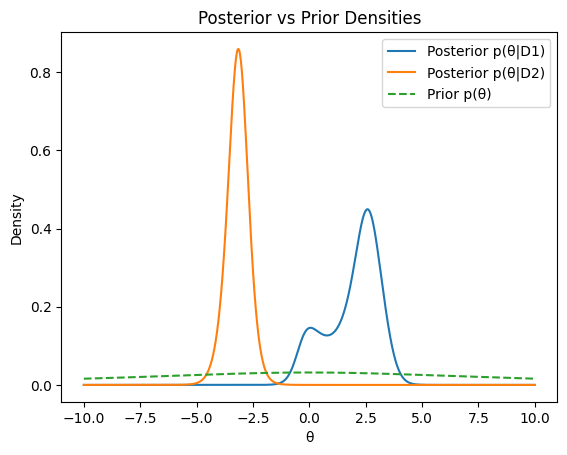

In [10]:
# Dataset and prior-based predictions
theta_values = np.linspace(-10, 10, 1000)

d1 = np.array([2.8, -0.4, -0.8, 2.3, -0.3, 3.6, 4.1])
d2 = np.array([-4.5, -3.4, -3.1, -3.0, -2.3])

# Compute posterior densities
posterior_d1 = compute_normalized_posterior(d1, theta_values)
posterior_d2 = compute_normalized_posterior(d2, theta_values)

# Plot posterior densities
plt.figure()
plt.plot(theta_values, posterior_d1, label="Posterior p(θ|D1)")
plt.plot(theta_values, posterior_d2, label="Posterior p(θ|D2)")
plt.plot(theta_values, [prior(theta) for theta in theta_values], label="Prior p(θ)", linestyle="--")
plt.xlabel("θ")
plt.ylabel("Density")
plt.legend()
plt.title("Posterior vs Prior Densities")
plt.show()

### **Observations About Bayesian Densities Compared to the Prior $p(\theta)$**

   - The posterior densities $p(\theta|D_1)$ and $p(\theta|D_2)$ have sharper peaks compared to the flat shape of the prior $p(\theta)$.
This indicates that the data strongly influences the posterior, concentrating the probability around specific $\theta$ values.
   - The prior $p(\theta)$ reflects initial uncertainty about $\theta$, being flat and spread out. After observing data, the posterior adjusts to focus on values of $\theta$ that best explain the data.
   - The posterior densities have smaller support compared to the prior, meaning they assign negligible probability to $\theta$ values far from the observed data's influence.
   - The posterior density represents a balance between the initial beliefs encoded in the prior and the evidence provided by the data. In $D_1$ and $D_2$, the posterior densities show a clear shift from the uniform-like prior towards data-driven peaks, highlighting the effect of observed data.

### **Conclusion**
- The prior provides an initial, broad expectation about $\theta$, while the posterior narrows this down to reflect the data's influence.
- The Bayesian approach refines the prior belief, making the posterior a more precise and evidence-based representation of $\theta$.


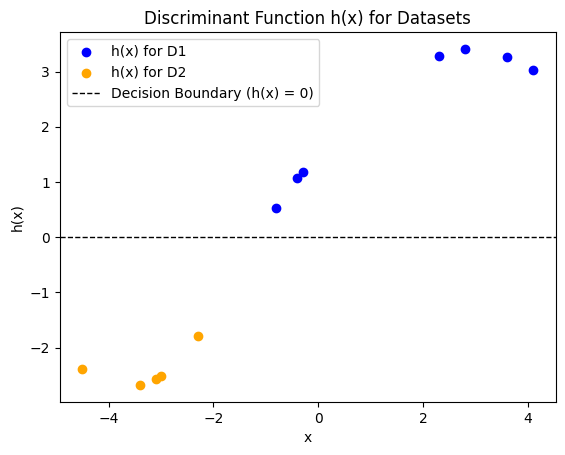

In [13]:
# Bayesian classifier
bayesian_classifier = BayesianClassifier()

# Predict h(x) for the datasets
prior_1 = len(d1) / (len(d1) + len(d2))
prior_2 = len(d2) / (len(d1) + len(d2))

h_values_d1 = bayesian_classifier.predict(d1, theta_values, posterior_d1, posterior_d2, prior_1, prior_2)
h_values_d2 = bayesian_classifier.predict(d2, theta_values, posterior_d1, posterior_d2, prior_1, prior_2)

# Plot h(x)
plt.figure()
plt.scatter(d1, h_values_d1, label="h(x) for D1", color="blue")
plt.scatter(d2, h_values_d2, label="h(x) for D2", color="orange")
plt.axhline(0, color="black", lw=1, linestyle="--", label="Decision Boundary (h(x) = 0)")
plt.xlabel("x")
plt.ylabel("h(x)")
plt.legend()
plt.title("Discriminant Function h(x) for Datasets")
plt.show()

### **Observations on $h(x)$ Values**

**Separation of Classes**:
   - The discriminant function $h(x)$ clearly separates the datasets $D_1$ and $D_2$.
   - For $D_1$, $h(x)$ values are predominantly positive, indicating $x$ is more likely to belong to $D_1$.
   - For $D_2$, $h(x)$ values are negative, indicating $x$ is more likely to belong to $D_2$.

**Comparison with MLE**
   - Compared to maximum likelihood estimation (MLE), Bayesian estimation results in smoother $h(x)$ values, reflecting the integration of uncertainty from the posterior densities.
   - The inclusion of prior information leads to more robust predictions, especially in regions where data is sparse.

**Reason for Differences**
- The difference arises because Bayesian estimation incorporates both the likelihood and the prior, while MLE considers only the likelihood.
- Bayesian methods account for uncertainty in $\theta$ by marginalizing over the posterior $p(\theta|D)$, which smoothens predictions and leads to more stable decision boundaries.
- MLE, being data-driven, may produce sharper but potentially less reliable decision boundaries, especially in cases with limited data.

### **Conclusion**
- Bayesian parameter estimation provides smoother and more reliable predictions due to its integration of prior knowledge and data evidence.
- MLE can be effective for larger datasets but may struggle in scenarios with uncertainty or limited information.
- In this example, Bayesian estimation yields better decision-making, as it leverages both the data and prior information to handle uncertainty effectively, especially near the $discriminant(x) = 0$ line, where our datasets have fewer data points.
